# **Trabalho de Redes Neurais: Detecção de Discurso de Ódio utilizando BiLSTM e Word2Vec**

**Objetivo:** Este notebook implementa e avalia o modelo de deep learning BiLSTM junto do vetorizador Word2Vec para a tarefa de detecção de discurso de ódio em tweets.

**Dataset:** Utiliza-se o MMHS150K, um conjunto de dados com 150.000 tweets contendo texto e imagem. Para esta primeira parte do trabalho, **focaremos exclusivamente na modalidade de texto.**

**Estratégia:**
Após uma análise inicial, observou-se um forte desbalanceamento entre as classes e, com isso, decidiu-se tratar como um problema binário ao invés de multiclasse, que, mesmo assim, ainda mantinha um alto desbalanceamento. Por esse motivo vamos implementar e comparar duas estratégias distintas para tratar esse desbalanceamento em um problema de classificação binária ("Hate" vs. "Não Hate"):
1. **Método 1:** Undersampling. Balancear o conjunto de treino cortando amostras da classe majoritária.
2. **Método 2:** Perda Ponderada (Weighted Loss). Usar o conjunto de treino completo, mas aplicando pesos na função de perda para dar mais importância à classe minoritária.

O objetivo final é determinar qual das duas abordagens produz um modelo mais eficaz e robusto para a detecção de discurso de ódio.

# **Configuração do Ambiente**

## **Instalações**

In [2]:
!pip install gensim scikit-learn pandas matplotlib torch keras nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## **Imports**

In [18]:
import os
import json
from collections import Counter
import nltk
import numpy as np
import pandas as pd
import re
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from gensim.models import Word2Vec
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Carregamento e Análise Exploratória dos Dados (EDA)**

O primeiro passo da análise é carregar os dados e entender sua estrutura. Realizamos uma análise exploratória na distribuição original de 6 classes para visualizar o desbalanceamento inicial, que motiva a simplificação do problema e a necessidade de técnicas de tratamento.

## **Carregamento dos Dados**

In [19]:
import kagglehub

path = kagglehub.dataset_download("victorcallejasf/multimodal-hate-speech")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/multimodal-hate-speech


In [20]:
print(os.listdir(path))

['splits', 'img_resized', 'img_txt', 'hatespeech_keywords.txt', 'MMHS150K_readme.txt', 'MMHS150K_GT.json']


In [21]:
json_gt_path = os.path.join(path, "MMHS150K_GT.json")

splits = {
    "Treino": os.path.join(path, "splits", "train_ids.txt"),
    "Validação": os.path.join(path, "splits", "val_ids.txt"),
    "Teste": os.path.join(path, "splits", "test_ids.txt"),
}


with open(json_gt_path, 'r') as f:
    data = json.load(f)

def contar_tweets(split_path):
    with open(split_path, 'r') as f:
        ids = [line.strip() for line in f.readlines()]
    return len([id_ for id_ in ids if id_ in data])

for nome_split, caminho_split in splits.items():
    total_tweets = contar_tweets(caminho_split)
    print(f"{nome_split}: {total_tweets} tweets")

Treino: 134823 tweets
Validação: 5000 tweets
Teste: 10000 tweets


## **Análise da Distribuição Multiclasse Original**

Distribuição Original das Classes no Conjunto Treino:
       Classe  Quantidade
1  Não é hate      108462
0     Racista       11333
4       Outro        6528
2     Sexista        4298
3  Homofóbico        3922
5    Religião         280


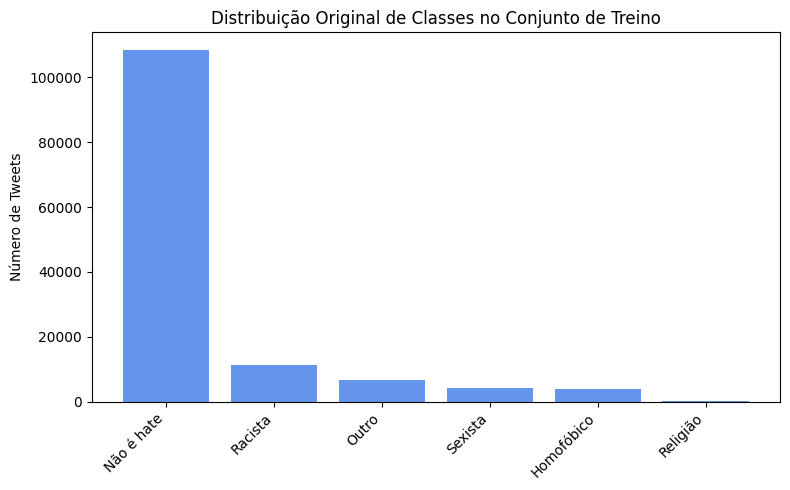

Distribuição Original das Classes no Conjunto Validação:
       Classe  Quantidade
4  Não é hate        2755
2     Racista         966
3       Outro         562
0     Sexista         366
1  Homofóbico         324
5    Religião          27


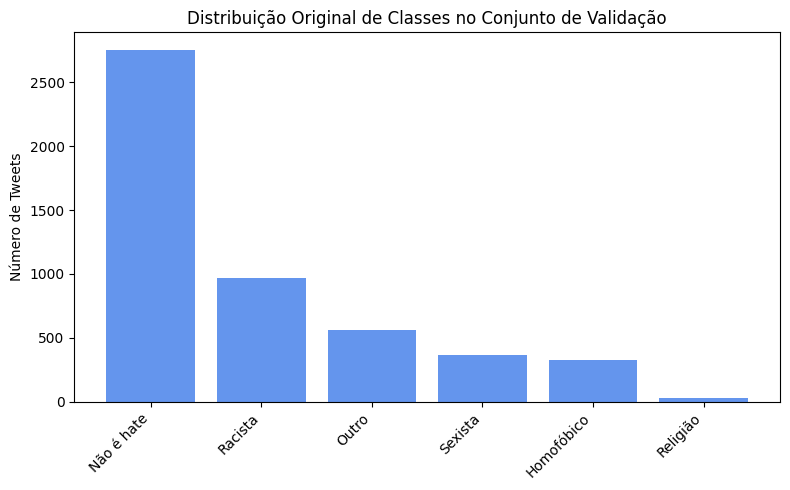

Distribuição Original das Classes no Conjunto Teste:
       Classe  Quantidade
3  Não é hate        5573
0     Racista        1884
1       Outro        1106
4     Sexista         711
2  Homofóbico         680
5    Religião          46


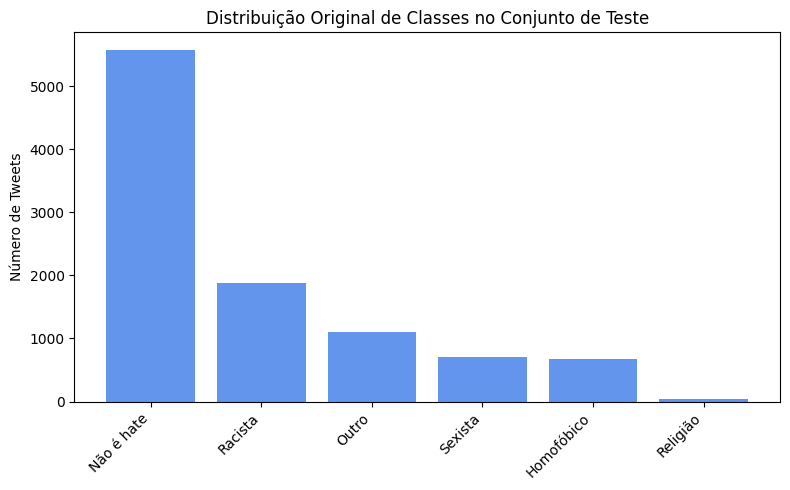

In [22]:
def carregar_dados_singlelabel(split_path, path_name):
    with open(split_path, 'r') as f:
        ids = [line.strip() for line in f.readlines()]
    texts = []
    labels = []
    for id_ in ids:
        if id_ in data:
            texts.append(data[id_]['tweet_text'])
            label_list = data[id_]['labels']  # ex: [0, 1, 1]
            most_common = Counter(label_list).most_common(1)[0][0]
            #if(most_common > 1): most_common = 1
            labels.append(most_common)  # pega a label majoritária

    # Mapeamento para nomes legíveis
    labels_map_multiclass = {
        0: "Não é hate", 1: "Racista", 2: "Sexista",
        3: "Homofóbico", 4: "Religião", 5: "Outro"
    }

    # Conta e plota a distribuição
    original_label_counts = Counter(labels)
    df_dist_multi = pd.DataFrame({
        'Classe': [labels_map_multiclass[label] for label, count in original_label_counts.items()],
        'Quantidade': [count for label, count in original_label_counts.items()]
    }).sort_values(by='Quantidade', ascending=False)

    print(f"Distribuição Original das Classes no Conjunto {path_name}:")
    print(df_dist_multi)

    # Plotando o gráfico
    plt.figure(figsize=(8, 5))
    plt.bar(df_dist_multi['Classe'], df_dist_multi['Quantidade'], color='cornflowerblue')
    plt.title(f'Distribuição Original de Classes no Conjunto de {path_name}')
    plt.ylabel('Número de Tweets')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    return texts, labels

train_texts, train_labels = carregar_dados_singlelabel(splits['Treino'], "Treino")
val_texts, val_labels = carregar_dados_singlelabel(splits['Validação'], "Validação")
test_texts, test_labels = carregar_dados_singlelabel(splits['Teste'], "Teste")

# **Binarização**

Devido ao desbalanceamento entre as classes "Hate" e "Não Hate" no dataset, optou-se por tratar o problema como uma classificação binária, focando apenas em distinguir os tweets como pertencentes a uma das duas categorias. Essa binarização simplifica a tarefa e permite uma avaliação mais clara do modelo.

In [23]:
def binarizacao(labels):
    for i, label in enumerate(labels):
        if label >= 1:
            labels[i] = 1
    return labels

train_labels = binarizacao(train_labels)
test_labels = binarizacao(test_labels)
val_labels = binarizacao(val_labels)

print(f"Distribuição Treino: Não Hate - {train_labels.count(0)} / Hate - {train_labels.count(1)}")
print(f"Distribuição Teste: Não Hate - {test_labels.count(0)} / Hate - {test_labels.count(1)}")
print(f"Distribuição Validação: Não Hate - {val_labels.count(0)} / Hate - {val_labels.count(1)}")

Distribuição Treino: Não Hate - 108462 / Hate - 26361
Distribuição Teste: Não Hate - 5573 / Hate - 4427
Distribuição Validação: Não Hate - 2755 / Hate - 2245


# **Pré-processamento**

Antes de alimentar os dados no modelo, é necessário realizar algumas etapas de pré-processamento no texto dos tweets. Isso inclui a remoção de caracteres especiais, links, e a tokenização, que consiste em dividir os textos em palavras individuais. Também é realizada a remoção de stopwords (palavras comuns que não contribuem para o significado, como "e", "a", "o"), além da conversão dos textos para minúsculas, para garantir consistência e evitar duplicações. Essas etapas são fundamentais para limpar os dados e preparar o modelo para aprender padrões relevantes.

In [24]:
# Carregar stopwords uma vez
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()

    # Substituir URLs e menções
    text = re.sub(r"http\S+|www\S+|https\S+", "<url>", text)
    text = re.sub(r"@\w+", "<user>", text)

    # Substituir hashtags mantendo a palavra
    text = re.sub(r"#(\w+)", r"\1", text)

    # Substituir emojis/emoticons por tags opcionais (pode usar emoji lib se quiser mais)
    text = re.sub(r"[^\w\s]", "", text)  # remove pontuação

    # Reduzir repetições de letras (ex: coooool → cool)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    return text

def normalize_obfuscated_words(tokens):
    """Substitui variações típicas ofensivas por palavras padrão (ex: f@gg0t → faggot)"""
    replacements = {
        r'b[\W_]*[i1!|][\W_]*t[\W_]*c[\W_]*h': 'bitch',
        r'f[\W_]*[a4@][\W_]*g[\W_]*g[\W_]*[o0][\W_]*t': 'faggot',
        r'n[\W_]*[i1!][\W_]*g[\W_]*g[\W_]*[e3][\W_]*[r4]': 'nigger',
        r'c[\W_]*[u*#][\W_]*n[\W_]*t': 'cunt',
        r'w[\W_]*h[\W_]*[o0][\W_]*r[\W_]*e': 'whore',
        r's[\W_]*l[\W_]*[u5][\W_]*t': 'slut',
        r'a[\W_]*s[\W_]*s[\W_]*h[\W_]*[o0][\W_]*l[\W_]*e': 'asshole',
        r't[\W_]*r[\W_]*a[\W_]*n[\W_]*n[\W_]*[y¥]': 'tranny',
        r'r[\W_]*[e3][\W_]*[t+][\W_]*a[\W_]*[r4][\W_]*d': 'retard'
    }
    normalized = []
    for token in tokens:
        replaced = token
        for pattern, standard in replacements.items():
            if re.fullmatch(pattern, token):
                replaced = standard
                break
        normalized.append(replaced)
    return normalized

def preprocess(text, remove_stopwords=False):
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = normalize_obfuscated_words(tokens)
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words]
    return tokens

In [25]:

tokenized_train_texts = [preprocess(text) for text in train_texts]
tokenized_val_texts = [preprocess(text) for text in val_texts]
tokenized_test_texts = [preprocess(text) for text in test_texts]

# **Treinamento do Modelo Word2Vec**

O modelo Word2Vec é utilizado para converter palavras em vetores numéricos densos, representando semelhanças semânticas entre elas. Para treinar o Word2Vec, os textos dos tweets, após o pré-processamento, são usados para criar um vocabulário. O modelo é treinado com esses dados para gerar embeddings de palavras, onde palavras semelhantes são representadas por vetores próximos no espaço vetorial. O Word2Vec captura as relações semânticas entre as palavras e é essencial para transformar o texto em uma representação numérica que o modelo de rede neural pode entender.

In [26]:

word2vec_model = Word2Vec(sentences=tokenized_train_texts, vector_size=100, window=5, min_count=1, workers=4)


In [27]:

vocab = {word: idx + 1 for idx, word in enumerate(word2vec_model.wv.index_to_key)}
vocab_size = len(vocab) + 1
embedding_dim = word2vec_model.vector_size

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in vocab.items():
    embedding_matrix[idx] = word2vec_model.wv[word]


# **Transformação dos Dados**

Após o treinamento do Word2Vec, os dados precisam ser transformados em um formato adequado para o modelo BiLSTM. Isso envolve converter as palavras dos tweets em vetores utilizando os embeddings gerados pelo Word2Vec. Cada tweet é representado por uma sequência de vetores, onde cada vetor corresponde a uma palavra do tweet. Além disso, os tweets podem ter tamanhos diferentes, então, é necessário padronizar o tamanho das sequências para que todas as entradas tenham o mesmo comprimento. Isso é feito através de padding, garantindo que as sequências mais curtas sejam preenchidas com valores nulos.

In [28]:
MAX_LEN = 50  # ou 100, dependendo do comprimento médio dos seus tweets

def tokens_to_indices(tokens_list, vocab):
    return [[vocab.get(token, 0) for token in tokens] for tokens in tokens_list]

train_sequences = tokens_to_indices(tokenized_train_texts, vocab)
val_sequences = tokens_to_indices(tokenized_val_texts, vocab)
test_sequences = tokens_to_indices(tokenized_test_texts, vocab)

train_padded = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# **Definição das Classes Necessárias ao Treinamento e Testes**

In [29]:

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx]), torch.tensor(self.labels[idx])


In [30]:

class BiLSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, dropout=0.5):
        super(BiLSTMClassifier, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        pooled = torch.mean(lstm_out, dim=1)
        out = self.dropout(pooled)
        return self.fc(out)


# **Criando Data Loaders e Tratamento por Undersampling**

O DataLoader é responsável por carregar os dados de forma eficiente durante o treinamento, garantindo que as amostras sejam fornecidas ao modelo em mini-lotes (batches). Isso facilita o treinamento, permitindo que o modelo seja alimentado com pequenos conjuntos de dados em cada iteração, melhorando a performance computacional.

No caso do desbalanceamento das classes, o undersampling é uma técnica utilizada para equilibrar a quantidade de exemplos entre as duas classes. Esse método reduz o número de amostras da classe majoritária ("Não Hate") para que haja uma distribuição mais equilibrada entre as classes. Com isso, o modelo evita ser tendencioso para a classe mais representada e aprende de maneira mais eficaz a identificar características do discurso de ódio.

In [31]:
train_dataset = TextDataset(train_padded, train_labels)
val_dataset = TextDataset(val_padded, val_labels)
test_dataset = TextDataset(test_padded, test_labels)

train_loader = DataLoader(train_dataset, batch_size= 2, shuffle=True)
val_loader = DataLoader(val_dataset)
test_loader = DataLoader(test_dataset)

# Undersampling Training

def balance_dataset(texts, labels):
    combined = list(zip(texts, labels))

    # Separate by class
    class_0 = [item for item in combined if item[1] == 0]
    class_1 = [item for item in combined if item[1] == 1]

    # Downsample the majority class
    min_len = min(len(class_0), len(class_1))
    class_0 = random.sample(class_0, min_len)
    class_1 = random.sample(class_1, min_len)

    # Combine and shuffle
    balanced = class_0 + class_1
    random.shuffle(balanced)

    balanced_texts, balanced_labels = zip(*balanced)
    return list(balanced_texts), list(balanced_labels)

train_bal_padded, train_bal_labels = balance_dataset(train_padded, train_labels)

train_balanced_dataset = TextDataset(train_bal_padded, train_bal_labels)
train_balanced_loader = DataLoader(train_balanced_dataset, shuffle=True)

# **Treinamento do Modelo BiLSTM com Undersampling**

No treinamento do modelo com undersampling, a classe majoritária é reduzida para balancear a distribuição entre as classes "Hate" e "Não Hate". Essa abordagem é utilizada para evitar que o modelo aprenda a favorecer a classe majoritária, o que poderia resultar em um desempenho ruim para a classe minoritária. Durante o treinamento, a função de perda e os parâmetros do modelo são ajustados com base nos dados balanceados, garantindo que o modelo seja treinado de maneira justa e que aprenda as características das duas classes de forma equilibrada. A técnica de undersampling permite uma avaliação mais precisa da performance do modelo, focando em um conjunto de dados mais representativo para ambas as classes.

In [32]:
print(torch.cuda.is_available())

True


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMClassifier(embedding_matrix, hidden_dim=128, output_dim=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_val_loss = float('inf')
patience = 3
trigger_times = 0

for epoch in range(20):
    model.train()
    running_loss = 0
    loop = tqdm(train_balanced_loader, desc=f"Epoch {epoch+1}", leave=False)

    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_balanced_loader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

    # Evaluate
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_inputs_batch, val_targets_batch in val_loader:
            val_inputs_batch, val_targets_batch = val_inputs_batch.to(device), val_targets_batch.to(device)
            val_outputs = model(val_inputs_batch)
            val_loss += criterion(val_outputs, val_targets_batch).item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), f'b_model.pth')
        print("Best model saved.")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1, Train Loss: 0.6229
Epoch 1, Val Loss: 0.6138
Best model saved.


Epoch 2, Train Loss: 0.5129
Epoch 2, Val Loss: 0.6949


Epoch 3, Train Loss: 0.4461
Epoch 3, Val Loss: 0.7846


Epoch 4, Train Loss: 0.4143
Epoch 4, Val Loss: 0.8241
Early stopping at epoch 4


# **Teste e Matriz de Confusão**

Após o treinamento, o modelo é avaliado utilizando um conjunto de dados de teste, que não foi visto durante o treinamento. Isso permite verificar como o modelo generaliza para novos dados e medir a sua capacidade de classificar corretamente os tweets em "Hate" e "Não Hate". A avaliação é feita com base em métricas de desempenho, como precisão, recall, F1-score e acurácia, que ajudam a entender a qualidade das previsões do modelo em relação à classe verdadeira de cada tweet.

Também é gerada uma matriz de confusão, uma ferramenta importante para visualizar o desempenho do modelo, mostrando a quantidade de acertos e erros em suas previsões. Ela é uma tabela que compara as classes preditas pelo modelo com as classes reais. A matriz de confusão gera quatro valores principais:

    True Positives (TP): Casos onde o modelo previu corretamente a classe "Hate".

    True Negatives (TN): Casos onde o modelo previu corretamente a classe "Não Hate".

    False Positives (FP): Casos onde o modelo previu erroneamente a classe "Hate" para tweets que eram "Não Hate".

    False Negatives (FN): Casos onde o modelo previu erroneamente a classe "Não Hate" para tweets que eram "Hate".

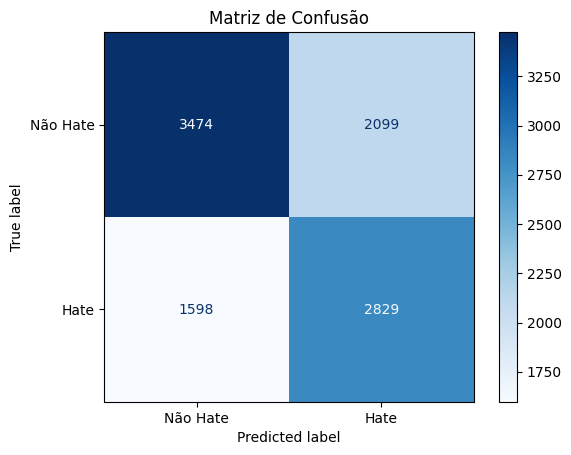


📊 Binary Classification Metrics:
Accuracy: 0.6303
Precision: 0.5741
Recall: 0.6390
F1-Score: 0.6048


In [ ]:
# Mapeamento das classes
class_mapping = {0: "Não Hate", 1: "Hate"}

all_targets = []
all_predictions = []

model.to(device)
model.eval()

with torch.no_grad():
    loop = tqdm(test_loader, desc="Evaluating", leave=False)
    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Substituindo 0 por "Não Hate" e 1 por "Hate"
all_targets_mapped = [class_mapping[target] for target in all_targets]
all_predictions_mapped = [class_mapping[pred] for pred in all_predictions]

# Matriz de Confusão
cm = confusion_matrix(all_targets_mapped, all_predictions_mapped, labels=["Não Hate", "Hate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Não Hate", "Hate"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()

# Calculate Accuracy
accuracy = accuracy_score(all_targets_mapped, all_predictions_mapped)

# Calculate Precision, Recall, and F1-score using the binary average
precision = precision_score(all_targets_mapped, all_predictions_mapped, average='binary', pos_label='Hate')
recall = recall_score(all_targets_mapped, all_predictions_mapped, average='binary', pos_label='Hate')
f1 = f1_score(all_targets_mapped, all_predictions_mapped, average='binary', pos_label='Hate')

# Display the results
print("\n📊 Binary Classification Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# **Treinamento do Modelo BiLSTM com Pesos**

No treinamento do modelo com pesos, o conjunto de dados original é utilizado, mantendo o desbalanceamento entre as classes "Hate" e "Não Hate". O modelo é treinado com todas as amostras disponíveis, e a função de perda pode ser ajustada com técnicas como weighted loss (perda ponderada) para garantir que a classe minoritária receba mais atenção durante o processo de aprendizado. Essa abordagem permite que o modelo aprenda com o conjunto completo de dados, sem eliminar amostras, o que pode ser vantajoso em alguns cenários. No entanto, o desbalanceamento das classes pode afetar a capacidade do modelo de generalizar corretamente para a classe minoritária, tornando importante a avaliação cuidadosa dos resultados obtidos.

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMClassifier(embedding_matrix, hidden_dim=128, output_dim=2).to(device)

label_counts = Counter(train_labels)
total_count = sum(label_counts.values())
class_weights = [total_count / label_counts[i] for i in range(len(label_counts))]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_val_loss = float('inf')
patience = 3
trigger_times = 0

for epoch in range(20):
    model.train()
    running_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

    # Evaluate
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_inputs_batch, val_targets_batch in val_loader:
            val_inputs_batch, val_targets_batch = val_inputs_batch.to(device), val_targets_batch.to(device)
            val_outputs = model(val_inputs_batch)
            val_loss += criterion(val_outputs, val_targets_batch).item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), f'b_model.pth')
        print("Best model saved.")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1, Train Loss: 0.5407
Epoch 1, Val Loss: 0.6529
Best model saved.


Epoch 2, Train Loss: 0.4840
Epoch 2, Val Loss: 0.6905


Epoch 3, Train Loss: 0.4447
Epoch 3, Val Loss: 0.7409


Epoch 4, Train Loss: 0.4218
Epoch 4, Val Loss: 0.7610
Early stopping at epoch 4


# **Teste e Matriz de Confusão**

Após o treinamento, o modelo é avaliado utilizando um conjunto de dados de teste, que não foi visto durante o treinamento. Isso permite verificar como o modelo generaliza para novos dados e medir a sua capacidade de classificar corretamente os tweets em "Hate" e "Não Hate". A avaliação é feita com base em métricas de desempenho, como precisão, recall, F1-score e acurácia, que ajudam a entender a qualidade das previsões do modelo em relação à classe verdadeira de cada tweet.

Também é gerada uma matriz de confusão, uma ferramenta importante para visualizar o desempenho do modelo, mostrando a quantidade de acertos e erros em suas previsões. Ela é uma tabela que compara as classes preditas pelo modelo com as classes reais. A matriz de confusão gera quatro valores principais:

    True Positives (TP): Casos onde o modelo previu corretamente a classe "Hate".

    True Negatives (TN): Casos onde o modelo previu corretamente a classe "Não Hate".

    False Positives (FP): Casos onde o modelo previu erroneamente a classe "Hate" para tweets que eram "Não Hate".

    False Negatives (FN): Casos onde o modelo previu erroneamente a classe "Não Hate" para tweets que eram "Hate".

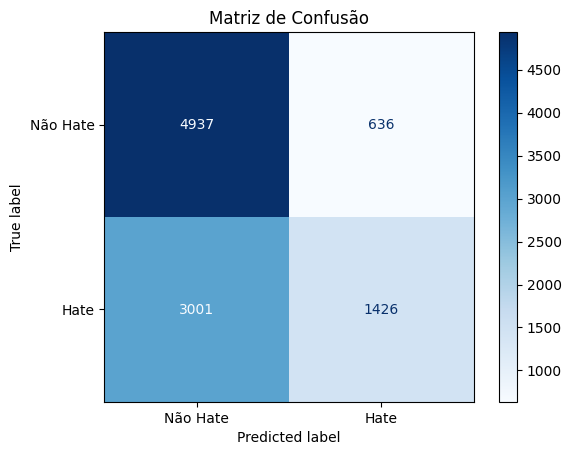


📊 Binary Classification Metrics:
Accuracy: 0.6363
Precision: 0.6916
Recall: 0.3221
F1-Score: 0.4395


In [34]:
# Mapeamento das classes
class_mapping = {0: "Não Hate", 1: "Hate"}

all_targets = []
all_predictions = []

model.to(device)
model.eval()

with torch.no_grad():
    loop = tqdm(test_loader, desc="Evaluating", leave=False)
    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Substituindo 0 por "Não Hate" e 1 por "Hate"
all_targets_mapped = [class_mapping[target] for target in all_targets]
all_predictions_mapped = [class_mapping[pred] for pred in all_predictions]

# Matriz de Confusão
cm = confusion_matrix(all_targets_mapped, all_predictions_mapped, labels=["Não Hate", "Hate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Não Hate", "Hate"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()

# Calculate Accuracy
accuracy = accuracy_score(all_targets_mapped, all_predictions_mapped)

# Calculate Precision, Recall, and F1-score using the binary average
precision = precision_score(all_targets_mapped, all_predictions_mapped, average='binary', pos_label='Hate')
recall = recall_score(all_targets_mapped, all_predictions_mapped, average='binary', pos_label='Hate')
f1 = f1_score(all_targets_mapped, all_predictions_mapped, average='binary', pos_label='Hate')

# Display the results
print("\n📊 Binary Classification Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# **Resultados**

Foram avaliados dois métodos distintos para o treinamento de um classificador BiLSTM com embeddings Word2Vec na tarefa de detecção de discurso de ódio:
1. Modelo com Balanceamento de Dados

Neste método, a base de dados de treino foi balanceada para conter uma proporção equitativa entre as classes "Hate" e "Não Hate". Os principais resultados obtidos na base de teste foram:

    Acurácia: 0.6303

    Precisão: 0.5741

    Recall: 0.6390

    F1-Score: 0.6048

A matriz de confusão mostra um bom equilíbrio entre verdadeiros positivos e verdadeiros negativos, indicando que o modelo conseguiu generalizar razoavelmente bem para ambas as classes.
2. Modelo com Ponderação de Classes

Neste segundo cenário, o modelo foi treinado utilizando a base original (desbalanceada), porém com penalidades diferenciadas para as classes por meio do parâmetro weight na função de perda. Os resultados na base de teste foram:

    Acurácia: 0.6363

    Precisão: 0.6916

    Recall: 0.3221

    F1-Score: 0.4395

Observa-se que este modelo tende a priorizar mais a classe majoritária ("Não Hate"), resultando em um menor recall, porém com leves ganhos na precisão.
Análise Comparativa

Ambos os métodos apresentaram desempenhos competitivos, mas com trade-offs distintos:

    O modelo com balanceamento de dados apresentou maior estabilidade geral nos resultados e menor viés para uma das classes.

    Já o modelo com ponderação de classes destacou-se na precisão, porém teve seus resultados enviesados para a classe majoritária que era "Não Hate".